# <center> **Plots figures Paper** <center>

## **Packages**

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import alphashape
import seaborn as sns
import pandas as pd
import json

from matplotlib.lines import Line2D
from matplotlib import rc
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr

from qibo import models
from qibo_analysis.qaoa_utils import exprectum_hamiltonian, create_gibbs_state, create_gausgibbs_state, expected_value, sample_state, build_maxcut_hamiltonian, build_mixer_hamiltonian

from variational_algorithms.tensor_networks.tn_algorithms import Pretraining
from variational_algorithms.use_cases.maxcut.instances import MaxCut_Instance
from variational_algorithms.use_cases.maxcut.cost_function import MaxCut_CostFunction
from variational_algorithms.tensor_networks.tensor_networks import TensorOperations

from sklearn.decomposition import PCA
from shapely.geometry import Polygon

## **Figure 3: Performance QAOA**

### **Gibbs State vs One State**

In [2]:
nodes_list = [8, 10, 12, 14, 16]
temperatures = [2, 4, 6]
layers_list = [5]

results = []

for temperature in temperatures:
    for layer in layers_list:
        for j in nodes_list:
            list_energy_qaoa_difference = []

            for i in range(30):
                
                path_data_qaoa = (
                    f"logger_data/logger_data_qaoa_performance_gibbs_states_borders_one_state/"
                    f"logger_data_max_cut_qaoa_common_instances_n_{j}_borders/"
                    f"cmaes_qaoa_max_cut_n_{j}_t_{temperature}_layers_{layer}_case_{i}.json"
                )

                try:
                    with open(path_data_qaoa) as f:
                        data = json.load(f)
                except FileNotFoundError:
                    print(f"File not found: {path_data_qaoa}")
                    continue

              
                energy_qaoa_gibbs_state = data['energy_qaoa_gibbs_state']
                energy_qaoa_one_state = data['energy_qaoa_one_state']
                energy_value_exact = data['energy_value_exact']
                
                relative_energy_qaoa_gibbs_state = (abs(energy_value_exact) - abs(energy_qaoa_gibbs_state)) / abs(energy_value_exact)
                relative_energy_qaoa_one_state = (abs(energy_value_exact) - abs(energy_qaoa_one_state)) / abs(energy_value_exact)
                        
                difference = relative_energy_qaoa_one_state - relative_energy_qaoa_gibbs_state
                list_energy_qaoa_difference.append(difference * 100)

       
            results.extend([{
                'energy_qaoa_difference': diff,
                'layers': layer,
                'temperature': temperature,
                'nodes': j
            } for diff in list_energy_qaoa_difference])


df_one_state = pd.DataFrame(results)

### **Gibbs States vs Hadamard State**

In [3]:
nodes_list = [8, 12, 16]  
temperatures = [1, 2, 3, 4, 5, 6]
layers_list = [5]


results = []


for nodes in nodes_list:
    for t in temperatures:
        for layers in layers_list:
            list_energy_qaoa_difference_layers_t = []
            
           
            for i in range(30):
                path_data_qaoa = f"logger_data/logger_data_qaoa_performance_gibbs_states_borders_hadamard_state/logger_data_max_cut_qaoa_common_instances_n_{nodes}_borders/cmaes_qaoa_max_cut_n_{nodes}_t_{t}_layers_{layers}_case_{i}.json"
                
                try:
                    with open(path_data_qaoa) as f:
                        data = json.load(f)
                except FileNotFoundError:
                    print(f"File not found: {path_data_qaoa}")
                    continue
                
           
                energy_qaoa_gibbs_state = data['energy_qaoa_gibbs_state']
                energy_qaoa_one_state = data['energy_qaoa_hadamard_state']
                energy_value_exact = data['energy_value_exact']
                
                relative_energy_qaoa_gibbs_state = (abs(energy_value_exact) - abs(energy_qaoa_gibbs_state)) / abs(energy_value_exact)
                relative_energy_qaoa_one_state = (abs(energy_value_exact) - abs(energy_qaoa_one_state)) / abs(energy_value_exact)
                
                difference = relative_energy_qaoa_one_state - relative_energy_qaoa_gibbs_state
                list_energy_qaoa_difference_layers_t.append(difference * 100)
            
            
            results.extend([{
                'energy_qaoa_difference': diff,
                'layers': layers,
                'temperature': t,
                'nodes': nodes
            } for diff in list_energy_qaoa_difference_layers_t])


df_hadamard = pd.DataFrame(results)

### **Gibbs States vs Gauss Gibbs**

In [4]:
nodes_list = [8, 12, 16]
temperatures = [0.3, 0.5, 0.7, 0.9]
layers_list = [5]  
num_cases = 9  


results = []


for nodes in nodes_list:
    for temp in temperatures:
        for layers in layers_list:
            list_entropy_gibbs_state = []
            list_entropy_pseudo_gibbs_state = []
            list_energy_qaoa_gibbs_state = []
            list_energy_qaoa_pseudo_gibbs_state = []
            
           
            for case_id in range(num_cases):
                path_data_qaoa = f"logger_data/logger_data_qaoa_performance_gibbs_states_temperature/logger_data_max_cut_qaoa_common_instances_n_{nodes}_temperature/cmaes_qaoa_max_cut_n_{nodes}_case_{case_id}_t_4_layers_{layers}_delta_gauss_{temp}.json"
                
                try:
                    with open(path_data_qaoa) as f:
                        data = json.load(f)
                except FileNotFoundError:
                    print(f"File not found: {path_data_qaoa}")
                    continue
                
              
                entropy_gibbs = data['entropy_gibbs_state']
                entropy_psgibbs = data['entropy_psgibbs_state']
                energy_qaoa_gibbs = data['energy_qaoa_gibbs_state']
                energy_qaoa_psgibbs = data['energy_qaoa_psgibbs_state']
                exact_energy = data['energy_value_exact']
                
                list_entropy_pseudo_gibbs_state.append(abs(entropy_psgibbs) / entropy_gibbs)
                list_entropy_gibbs_state.append(entropy_gibbs / entropy_gibbs)
                list_energy_qaoa_gibbs_state.append((abs(exact_energy) - abs(energy_qaoa_gibbs)) / abs(exact_energy))
                list_energy_qaoa_pseudo_gibbs_state.append((abs(exact_energy) - abs(energy_qaoa_psgibbs)) / abs(exact_energy))
            

            results.append({
                'nodes': nodes,
                'temperature': temp,
                'layers': layers,
                'entropy_gibbs_state': np.mean(list_entropy_gibbs_state), 
                'entropy_pseudo_gibbs_state': np.mean(list_entropy_pseudo_gibbs_state), 
                'energy_qaoa_gibbs_state': np.mean(list_energy_qaoa_gibbs_state),  
                'energy_qaoa_pseudo_gibbs_state': np.mean(list_energy_qaoa_pseudo_gibbs_state)  
            })


df_gauss = pd.DataFrame(results)

### **Final Plot**

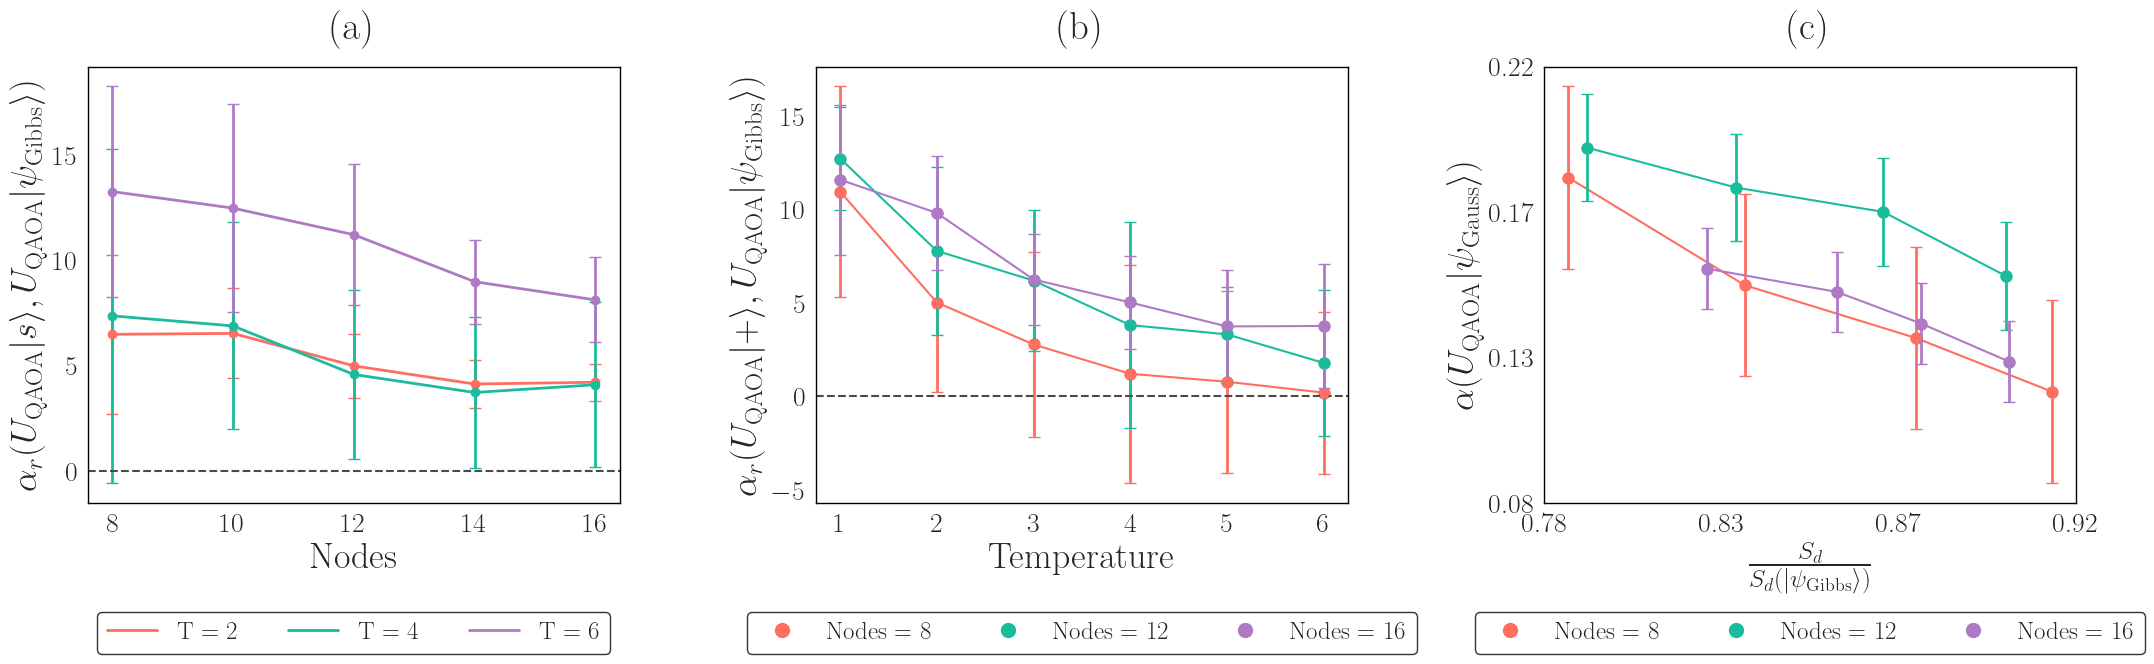

In [5]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.weight'] = 'black'
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

sns.set_style("whitegrid", {
    'font.family': 'serif', 
    'text.usetex': True,
    'font.weight': 'bold',
    'text.latex.preamble': r'\usepackage{amsmath}'
})


pastel_colors_custom = [
    '#ff6f61', 
    '#1abc9c', 
    '#af7ac5',  
    '#27ae60'   
]



font_size_title = 28
font_size_labels = 26
font_size_legend = 18


fig, axs = plt.subplots(1, 3, figsize=(22, 7), sharex=False, sharey=False)


summary_df = df_one_state.groupby(['nodes', 'temperature', 'layers']).agg(
    mean_energy_qaoa_difference=('energy_qaoa_difference', 'mean'),
    std_energy_qaoa_difference=('energy_qaoa_difference', 'std')
).reset_index()

temperature_colors = {temp: pastel_colors_custom[i % len(pastel_colors_custom)] 
                      for i, temp in enumerate(sorted(summary_df['temperature'].unique()))}

x_ticks = set()
for (temperature, layer) in summary_df[['temperature', 'layers']].drop_duplicates().values:
    subset = summary_df[(summary_df['temperature'] == temperature) & (summary_df['layers'] == layer)]
    subset = subset.sort_values(by='nodes')
    color = temperature_colors.get(temperature, 'k')
    
    axs[0].plot(
        subset['nodes'],
        subset['mean_energy_qaoa_difference'],
        color=color,
        linestyle='-',
        linewidth=2,
        label=f'T = {temperature}'
    )
    
    axs[0].errorbar(
        subset['nodes'],
        subset['mean_energy_qaoa_difference'],
        yerr=subset['std_energy_qaoa_difference'],
        fmt='o',
        color=color,
        ecolor=color,
        elinewidth=2,
        capsize=4,
        label='_nolegend_'
    )
    
    x_ticks.update(subset['nodes'])

axs[0].set_xticks(sorted(x_ticks))
line_legend_elements = [Line2D([0], [0], color=temperature_colors[temp], linestyle='-', linewidth=2, label=f'T = {temp}') for temp in sorted(summary_df['temperature'].unique())]
axs[0].legend(handles=line_legend_elements, bbox_to_anchor=(0.5, -0.25), loc='upper center', borderaxespad=0., ncol=3, fontsize=font_size_legend, frameon=True, edgecolor='black')
axs[0].set_title("(a)", fontsize=font_size_title, pad=20, weight = 'black')
axs[0].set_xlabel('Nodes', fontsize=font_size_labels)
axs[0].set_ylabel(r'$\alpha_{r}(U_{\text{QAOA}}|s \rangle, U_{\text{QAOA}}|\psi_{\textrm{Gibbs}} \rangle)$', fontsize=font_size_labels)


summary_df = df_hadamard.groupby(["nodes", "temperature", "layers"]).agg(
    mean_energy_qaoa_difference=("energy_qaoa_difference", "mean"),
    std_energy_qaoa_difference=("energy_qaoa_difference", "std"),
).reset_index()

color_map = {node: pastel_colors_custom[i % len(pastel_colors_custom)] 
             for i, node in enumerate(sorted(summary_df["nodes"].unique()))}

line_styles = {3: "-", 5: "-"}
markers = {3: "^", 5: "o"}

x_ticks = set()
for node, layer in summary_df[["nodes", "layers"]].drop_duplicates().values:
    subset = summary_df[(summary_df["nodes"] == node) & (summary_df["layers"] == layer)]
    subset = subset.sort_values(by="temperature")
    marker = markers.get(layer, "o")
    color = color_map.get(node, 'k')
    
    axs[1].plot(
        subset["temperature"],
        subset["mean_energy_qaoa_difference"],
        color=color,
        linestyle=line_styles.get(layer, "-"),
        marker=marker,
        markersize=8,
        label=f"Nodes = {node}",
    )
    
    axs[1].errorbar(
        subset["temperature"],
        subset["mean_energy_qaoa_difference"],
        yerr=subset["std_energy_qaoa_difference"],
        fmt='o',
        color=color,
        ecolor=color,
        elinewidth=2,
        capsize=4,
        label="_nolegend_"
    )
    
    x_ticks.update(subset["temperature"])

axs[1].set_xticks(sorted(x_ticks))
color_legend_elements = [Line2D([0], [0], color=color_map[node], marker="o", linestyle="None", markersize=10, label=f"Nodes = {node}") for node in sorted(summary_df["nodes"].unique())]
axs[1].legend(handles=color_legend_elements, bbox_to_anchor=(0.5, -0.25), loc="upper center", borderaxespad=0.0, ncol=3, fontsize=font_size_legend,frameon=True, edgecolor='black')
axs[1].set_title("(b)", fontsize=font_size_title,  pad=20)
axs[1].set_xlabel("Temperature", fontsize=font_size_labels)
axs[1].set_ylabel(r"$\alpha_{r}(U_{\text{QAOA}}|+ \rangle, U_{\text{QAOA}}|\psi_{\textrm{Gibbs}} \rangle)$", fontsize=font_size_labels)

nodes_list = sorted(df_gauss['nodes'].unique())
color_map = {node: pastel_colors_custom[i % len(pastel_colors_custom)] for i, node in enumerate(nodes_list)}

marker = "o"

for node in nodes_list:
    subset = df_gauss[df_gauss['nodes'] == node]
    
    x_means = subset['entropy_pseudo_gibbs_state']
    y_means = subset['energy_qaoa_pseudo_gibbs_state']
    y_std = subset['energy_qaoa_pseudo_gibbs_state'].std()
    
    axs[2].plot(
        x_means,
        y_means,
        marker=marker,
        linestyle="-",
        color=color_map[node],
        markersize=8,
        label=f'Nodes={node}'
    )

    axs[2].errorbar(
        x_means,
        y_means,
        yerr=y_std,
        fmt='o',
        color=color_map[node],
        ecolor=color_map[node],
        elinewidth=2,
        capsize=4,
        label='_nolegend_'
    )

axs[2].legend(handles=color_legend_elements, bbox_to_anchor=(0.5, -0.25), loc="upper center", borderaxespad=0.0, ncol=3, fontsize=font_size_legend, frameon=True, edgecolor='black')

axs[2].set_xlabel(r'$\frac{S_{d}}{S_{d}(|\psi_{\textrm{Gibbs}} \rangle)}$', fontsize=font_size_labels)
axs[2].set_ylabel(r"$\alpha(U_{\text{QAOA}}|\psi_{\textrm{Gauss}} \rangle)$", fontsize=font_size_labels)
axs[2].set_title('(c)', fontsize=font_size_title, pad=20)

axs[0].axhline(y=0, color='#4A4A4A', linestyle='--')
axs[1].axhline(y=0, color='#4A4A4A', linestyle='--')

axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)

x_min, x_max = axs[2].get_xlim()
y_min, y_max = axs[2].get_ylim()

axs[2].set_xticks(np.linspace(x_min, x_max, 4))  
axs[2].set_yticks(np.linspace(y_min, y_max, 4))

for ax in [axs[0], axs[1], axs[2]]:
    for spine in ax.spines.values():
        spine.set_edgecolor('black') 
        spine.set_linewidth(1)
        ax.tick_params(axis='both', which='major', labelsize=20)
        
axs[2].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}'))
axs[2].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}'))


plt.tight_layout()
plt.show()

## **Figure 4: Gibbs states heat map**

In [6]:
ruta_json = f'logger_data/logger_data_qaoa_performance_gibbs_states_heat_map/case_4_heat_map_n_6_layers_3.json'

df = pd.read_json(ruta_json)

exact_energy_number = abs(df['exact_energy'][0])

energy_qaoa_hadamard_state_number = df['energy_qaoa_hadamard_state'][0]

df_nuevo = pd.DataFrame()

df_nuevo['energy']= pd.concat([df['energy_pseudo_gibbs_state'], 
                               df['energy_gibbs_state'], 
                               df['energy_one_state_final'],
                               df['energy_hadamard_state'],
                               df['energy_one_state'],
                               df['energy_random_state'],
                               ], 
                               axis=0, ignore_index=True)

df_nuevo['entropy']= pd.concat([df['entropy_pseudo_gibbs_state'], 
                                df['entropy_gibbs_state'],
                                df['entropy_one_state_final'],  
                                df['entropy_hadamard_state'],
                                df['entropy_one_state'],
                                df['entropy_random_state'],
                                ], 
                                axis=0, ignore_index=True)

df_nuevo['energy_QAOA']= pd.concat([df['energy_qaoa_pseudo_gibbs_state'], 
                                    df['energy_qaoa_gibbs_state'],
                                    df['energy_qaoa_one_state_final'], 
                                    df['energy_qaoa_hadamard_state'],
                                    df['energy_qaoa_one_state'],
                                    df['energy_qaoa_random_state'],
                                    ], 
                                    axis=0, ignore_index=True)

def find_closest_e_sol_gibbs(row, df):
    closest_idx = (np.abs(df['energy_gibbs_state'] - row['energy'])).idxmin()
    return df.at[closest_idx, 'energy_qaoa_gibbs_state']


df_nuevo['energy_ref_gibbs'] = df_nuevo.apply(find_closest_e_sol_gibbs, axis=1, df=df)

df_nuevo['relative_energy_exact'] = -(df_nuevo['energy_QAOA'].abs() - exact_energy_number)/exact_energy_number

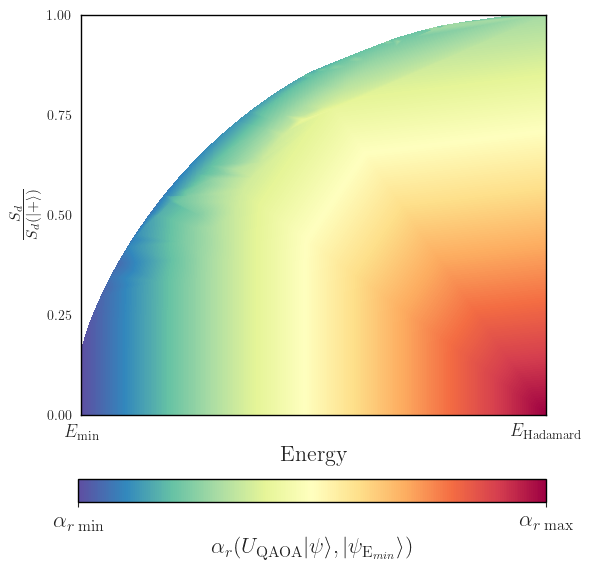

In [7]:
sns.set_style("whitegrid", {
    'font.family': 'serif', 
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}'
})


fig, ax = plt.subplots(figsize=(6, 8))


x_min, x_max = df_nuevo['energy'].min(), df_nuevo['energy'].max()
y_min, y_max = df_nuevo['entropy'].min(), df_nuevo['entropy'].max()

x_grid, y_grid = np.mgrid[x_min:x_max:10000j, y_min:y_max:10000j]


points = np.array(df_nuevo[['energy', 'entropy']])
values = np.array(df_nuevo['relative_energy_exact'])
z_grid = griddata(points, values, (x_grid, y_grid), method='linear')


z_min, z_max = np.nanmin(z_grid), np.nanmax(z_grid)
z_grid_normalized = (z_grid - z_min) / (z_max - z_min)

cmap = sns.color_palette("Spectral", as_cmap=True).reversed()

sigma = 3
z_grid_smooth = gaussian_filter(z_grid_normalized, sigma=sigma)


im = ax.imshow(z_grid_smooth.T, extent=(x_min, x_max, y_min, y_max), origin='lower', 
               cmap=cmap, aspect='auto', alpha=1, interpolation='none')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.2, aspect=20)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$\alpha_{r}(U_{\text{QAOA}}|\psi \rangle, |\psi_{\textrm{E}_{min}} \rangle)$', fontsize=16)
cbar.ax.set_position([0.12, 0.22, 0.78, 0.08]) 
cbar.set_ticks([0, 1])
cbar.set_ticklabels([r'$\alpha_{r \; \textrm{min}}$', r'$\alpha_{r \; \textrm{max}}$'], fontsize=16)

cbar.outline.set_edgecolor('black')  
cbar.outline.set_linewidth(1)   


ax.set_xticks([x_min, x_max])
ax.set_xticklabels([r'$E_{\textrm{min}}$', r'$E_{\textrm{Hadamard}}$'], fontsize=13)
ax.set_ylabel(r'$\frac{S_{d}}{S_{d}(| + \rangle)}$', fontsize=16)

y_ticks = np.linspace(y_min, y_max, 5) 
ax.set_yticks(y_ticks)
ax.tick_params(axis='y', labelsize=10) 

ax.set_xlabel('Energy', fontsize=16)

for ax in [ax]:
    for spine in ax.spines.values():
        spine.set_edgecolor('black') 
        spine.set_linewidth(1)

plt.grid(False)
plt.show()

## **Figure 5: Landscapes Gibbs states**

In [8]:
n = 8
p = 0.5

G = nx.erdos_renyi_graph(n, p, seed = 1)

dict_values = exprectum_hamiltonian(G)

gibbs_state = create_gibbs_state(dict_values, t = 3)
expected_value_gibbs_state = expected_value(state = gibbs_state, dict_values = dict_values)

pseudo_gibbs_state = create_gausgibbs_state(solutions_dict = dict_values, 
                                            delta_energy = 0.6, 
                                            mu_energy = expected_value_gibbs_state)

expected_value_psgibbs_state = expected_value(state=pseudo_gibbs_state, dict_values=dict_values)

dict_pb_gibbs = sample_state(gibbs_state)

pb_gibbs = list(dict_pb_gibbs.values())

entropy_gibbs = -sum(
pb_gibbs[i] * np.log2(pb_gibbs[i])
for i in range(len(pb_gibbs))
if pb_gibbs[i] != 0 )

dict_pb_psgibbs = sample_state(pseudo_gibbs_state)

pb_psgibbs = list(dict_pb_psgibbs.values())

entropy_psgibbs = -sum(
    pb_psgibbs[i] * np.log2(pb_psgibbs[i])
    for i in range(len(pb_psgibbs))
    if pb_psgibbs[i] != 0
        )

hamiltonian = build_maxcut_hamiltonian(graph = G)

mixer_hamiltonian = build_mixer_hamiltonian(graph = G)

print('Energy Gibbs:', expected_value_gibbs_state, 'Entropy Gibbs:', entropy_gibbs)
print('Energy PsGibbs:', expected_value_psgibbs_state, 'Entropy PsGibbs:', entropy_psgibbs)


alpha = np.linspace(- np.pi, np.pi, 60)
beta = np.linspace(0, np.pi, 60)

energy_psgibbs_dict_mc = {}

for a in alpha:
    for b in beta:
        
        final_parameters = np.array([a, b])
        
        qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)
        
        qaoa.set_parameters(final_parameters)
        
        quantum_state = qaoa.execute(initial_state = pseudo_gibbs_state)
        
        value = expected_value(state = quantum_state, dict_values = dict_values)
        
        energy_psgibbs_dict_mc[(a, b)] = value
        
energy_gibbs_dict_mc = {}

for a in alpha:
    for b in beta:
        
        final_parameters = np.array([a, b])
        
        qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)
        
        qaoa.set_parameters(final_parameters)
        
        quantum_state = qaoa.execute(initial_state = gibbs_state)
        
        value = expected_value(state = quantum_state, dict_values = dict_values)
        
        energy_gibbs_dict_mc[(a, b)] = value

[Qibo 0.2.16|INFO|2025-02-27 17:42:51]: Using qibojit (numba) backend on /CPU:0


Energy Gibbs: -10.3768304085542 Entropy Gibbs: 7.206914416239607
Energy PsGibbs: -10.198064670411446 Entropy PsGibbs: 6.017836234537554


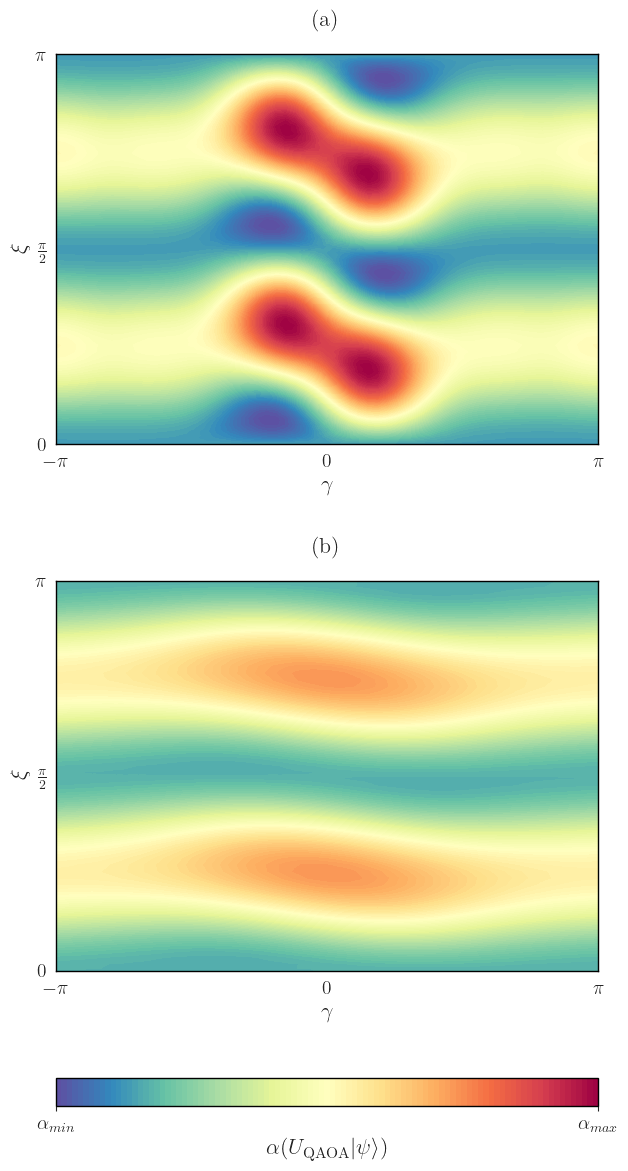

In [9]:
sns.set_style("whitegrid", {
    'font.family': 'serif', 
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}'
})


plt.rcParams['axes.titlesize'] = 16  
plt.rcParams['axes.labelsize'] = 16  
plt.rcParams['xtick.labelsize'] = 14 
plt.rcParams['ytick.labelsize'] = 14 

x_gibbs, y_gibbs = zip(*energy_gibbs_dict_mc.keys())
z_gibbs = np.array(list(energy_gibbs_dict_mc.values()))  

x_psgibbs, y_psgibbs = zip(*energy_psgibbs_dict_mc.keys())
z_psgibbs = np.array(list(energy_psgibbs_dict_mc.values()))  

x_gibbs = np.array(x_gibbs)
y_gibbs = np.array(y_gibbs)
z_gibbs = np.array(z_gibbs)

x_psgibbs = np.array(x_psgibbs)
y_psgibbs = np.array(y_psgibbs)
z_psgibbs = np.array(z_psgibbs)

cmap = sns.color_palette("Spectral", as_cmap=True, n_colors=100)
cmap = cmap.reversed()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 14))  

plt.subplots_adjust(hspace=0.35)

z_min = min(z_gibbs.min(), z_psgibbs.min())
z_max = max(z_gibbs.max(), z_psgibbs.max())

sc1 = ax1.tricontourf(x_gibbs, y_gibbs, z_gibbs, cmap=cmap, levels=np.linspace(z_min, z_max, 100))
ax1.set_xlabel(r"$\gamma$")
ax1.set_ylabel(r"$\xi$")
ax1.set_title("(a)", pad=20)

pi_ticks_gamma = [-np.pi ,0, np.pi]
pi_ticks_beta = [0, np.pi/2, np.pi]

pi_labels_gamma = [r'$-\pi$', r'$0$', r'$\pi$']
pi_labels_beta = [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']

ax1.set_xticks(pi_ticks_gamma)
ax1.set_xticklabels(pi_labels_gamma)
ax1.set_yticks(pi_ticks_beta)
ax1.set_yticklabels(pi_labels_beta)

sc2 = ax2.tricontourf(x_psgibbs, y_psgibbs, z_psgibbs, cmap=cmap, levels=np.linspace(z_min, z_max, 100))
ax2.set_xlabel(r"$\gamma$")
ax2.set_ylabel(r"$\xi$")
ax2.set_title("(b)", pad=20)

ax2.set_xticks(pi_ticks_gamma)
ax2.set_xticklabels(pi_labels_gamma)
ax2.set_yticks(pi_ticks_beta)
ax2.set_yticklabels(pi_labels_beta)

for ax in [ax1, ax2]:
    for spine in ax.spines.values():
        spine.set_edgecolor('black') 
        spine.set_linewidth(1)


cbar = fig.colorbar(sc1, ax=[ax1, ax2], orientation='horizontal', fraction=0.05, pad=0.1, aspect=20)
cbar.set_label(r'$\alpha(U_{\text{QAOA}}| \psi \rangle)$', fontsize=16)

cbar.set_ticks([z_min, z_max])
cbar.set_ticklabels([r'$\alpha_{min}$', r'$\alpha_{max}$'])
cbar.outline.set_edgecolor('black') 
cbar.outline.set_linewidth(1)   

plt.show()

## **Figure 6: Expressivity Gibbs states**

In [ ]:
results = pd.read_csv("logger_data/logger_data_qaoa_performance_gibbs_states_expressivity_random_energy_n_10")

max_index = results['Variance'].idxmax() 
results = results.drop(max_index)   

results['Area_norm'] = results['Area'] / results['Area'].max()
results['Variance_norm'] = results['Variance'] / results['Variance'].max()

C:\Users\anava\AppData\Local\Temp\ipykernel_2072\2133749609.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


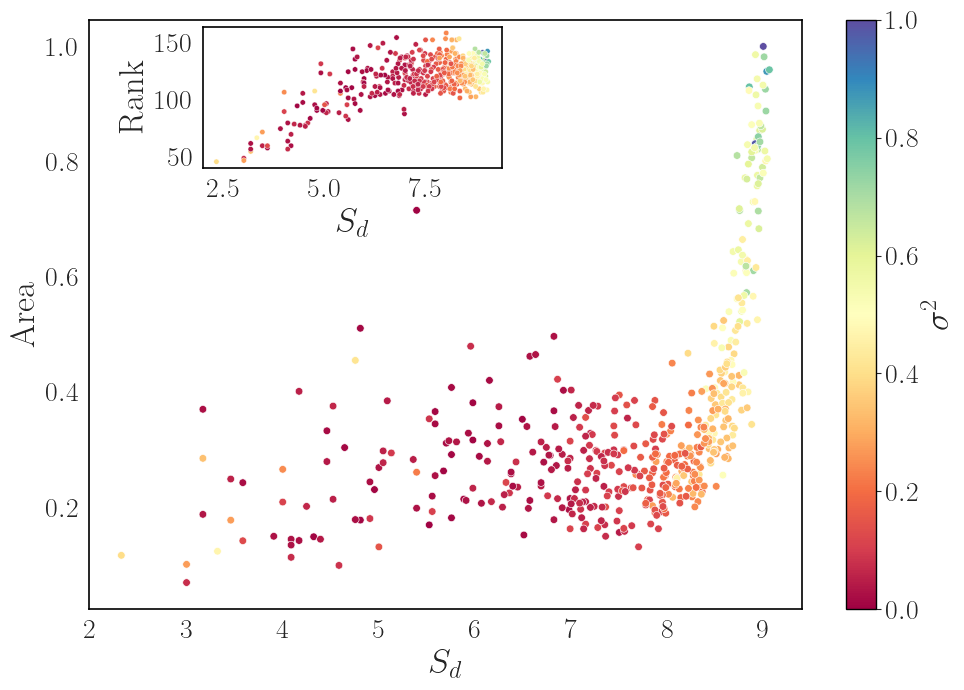

In [15]:
spectral_cmap = sns.color_palette("Spectral", as_cmap=True)

fig, ax1 = plt.subplots(figsize=(10, 7))

sns.scatterplot(
    x='Entropy', 
    y='Area_norm', 
    data=results, 
    ax=ax1,
    hue='Variance_norm',      
    palette=spectral_cmap,      
    hue_norm=(0, 1),           
    s=30,                     
    marker='o',           
    legend=False      
)
ax1.set_xlabel(r'$S_{d}$', fontsize=25, family='serif')
ax1.set_ylabel('Area', fontsize=25, family='serif')

norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap=spectral_cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax1, label=r'$\sigma^{2}$')
cbar.set_label(r'$\sigma^{2}$', fontsize=25)
cbar.ax.tick_params(labelsize=20)
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1)

ax2 = inset_axes(
    ax1, 
    width="30%", 
    height="20%", 
    loc='upper left', 
    bbox_to_anchor=(0.15, -0.2, 1.4, 1.2), 
    bbox_transform=ax1.transAxes
)
sns.scatterplot(
    x='Entropy', 
    y='Rank', 
    data=results, 
    ax=ax2, 
    hue='Variance_norm',     
    palette=spectral_cmap,   
    hue_norm=(0, 1),           
    s=15,                     
    marker='o',               
    legend=False              
)
ax2.set_xlabel(r'$S_{d}$', fontsize=25, family='serif')
ax2.set_ylabel('Rank', fontsize=25, family='serif')

ax1.tick_params(axis='both', labelsize=20)
ax2.tick_params(axis='both', labelsize=20)
plt.rc('font', family='serif')
ax1.grid(False)
ax2.grid(False)

for ax in [ax1, ax2]:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()

## **Figure 7: Quantum-classical optimization**

In [16]:
########################################## 30 ##########################################

path_data_qaoa_tevo_30 = r"logger_data\logger_data_pretraining_su4\pretraining_mpo_time_evolution_qaoa\case_0_tevo_qaoa_linear_t_30_dt_01.json"
        
with open(path_data_qaoa_tevo_30) as f:
    
    data_tevo_30 = json.load(f)


exact_energy = data_tevo_30['exact_energy']
energy_tevo_30 = [abs(data_tevo_30['energy_tevo'][i] - exact_energy)/abs(exact_energy) for i in range(len(data_tevo_30['energy_tevo']))]

path_data_qaoa_tevo_quantum_30 = r"logger_data\logger_data_pretraining_su4\pretraining_mpo_time_evolution_qaoa\case_0_tevo_qaoa_linear_quantum_t_30_dt_01.json"
        
with open(path_data_qaoa_tevo_quantum_30) as f:
    
    data_tevo_qaoa_30 = json.load(f)

data_qaoa_30 = [abs(data_tevo_qaoa_30[i]['energy'] - exact_energy)/abs(exact_energy) for i in range(len(data_tevo_qaoa_30))]


########################################## 50 ##########################################

path_data_qaoa_tevo_50 = r"logger_data\logger_data_pretraining_su4\pretraining_mpo_time_evolution_qaoa\case_0_tevo_qaoa_linear_t_50_dt_01.json"
        
with open(path_data_qaoa_tevo_50) as f:
    
    data_tevo_50 = json.load(f)


exact_energy = data_tevo_50['exact_energy']
energy_tevo_50 = [abs(data_tevo_50['energy_tevo'][i] - exact_energy)/abs(exact_energy) for i in range(len(data_tevo_50['energy_tevo']))]


path_data_qaoa_tevo_quantum_50 = r"logger_data\logger_data_pretraining_su4\pretraining_mpo_time_evolution_qaoa\case_0_tevo_qaoa_linear_quantum_t_50_dt_01.json"
        
with open(path_data_qaoa_tevo_quantum_50) as f:
    
    data_tevo_qaoa_50 = json.load(f)

data_qaoa_50 = [abs(data_tevo_qaoa_50[i]['energy'] - exact_energy)/abs(exact_energy) for i in range(len(data_tevo_qaoa_50))]

########################################## Hadamard ##########################################


path_data_qaoa_tevo_quantum_hadamard = r"logger_data\logger_data_pretraining_su4\pretraining_mpo_time_evolution_qaoa\case_0_tevo_qaoa_linear_quantum_hadamard.json"
        
with open(path_data_qaoa_tevo_quantum_hadamard) as f:
    
    data_tevo_qaoa_hadamard = json.load(f)

data_qaoa_hadamard = [abs(data_tevo_qaoa_hadamard[i]['energy'] - exact_energy)/abs(exact_energy) for i in range(len(data_tevo_qaoa_hadamard))]


C:\Users\anava\AppData\Local\Temp\ipykernel_2072\3919445794.py:37: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, len(data_qaoa_hadamard_smooth))


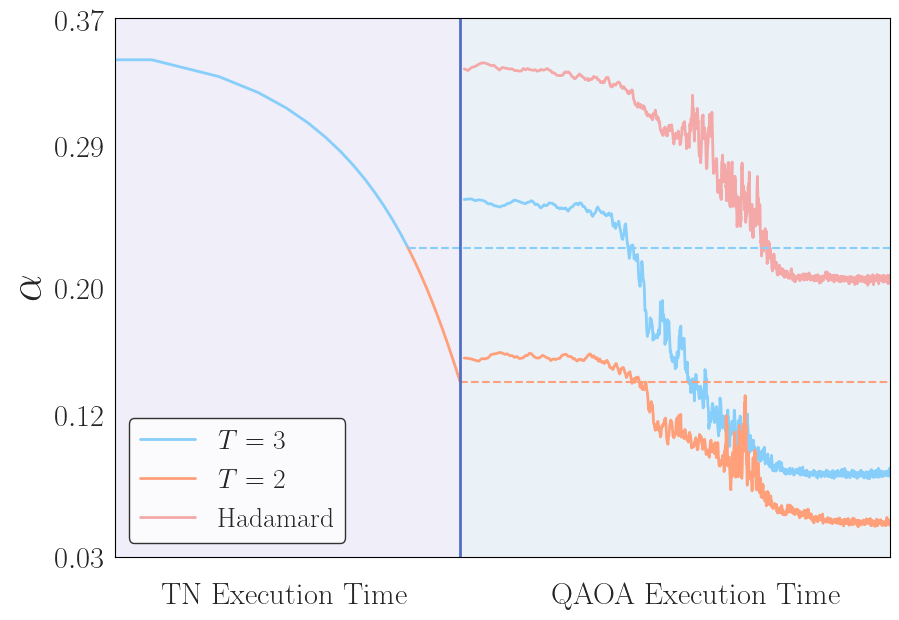

In [17]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

rc('text', usetex=True)
rc('font', family='serif', weight='bold')


energy_tevo_50_smooth = [energy_tevo_50[i] for i in range(1, len(energy_tevo_50), 2)]

window_size = 5
data_qaoa_30_smooth = moving_average(data_qaoa_30, 
                                     window_size=window_size)
data_qaoa_50_smooth = moving_average(data_qaoa_50, window_size=window_size)
data_qaoa_hadamard_smooth = moving_average(data_qaoa_hadamard, window_size=window_size)


plt.figure(figsize=(10, 7))
plt.xscale('log')

sns.lineplot(x=range(15), y=energy_tevo_50_smooth[:15], linestyle='-', linewidth=2, color='#87CEFA')
sns.lineplot(x=range(14, len(energy_tevo_50_smooth)), y=energy_tevo_50_smooth[14:], linestyle='-', linewidth=2, color='#FFA07A')

start_point = len(energy_tevo_50_smooth)

sns.lineplot(x=range(start_point, start_point + len(data_qaoa_30_smooth)), 
             y=data_qaoa_30_smooth, label=r'$T=3$', linestyle='-', linewidth=2, color = '#87CEFA')

sns.lineplot(x=range(start_point, start_point + len(data_qaoa_50_smooth)), 
             y=data_qaoa_50_smooth, label=r'$T=2$', linestyle='-', linewidth=2, color = '#FFA07A')

sns.lineplot(x=range(start_point, start_point + len(data_qaoa_hadamard_smooth)), 
             y=data_qaoa_hadamard_smooth, label='Hadamard', linestyle='-', linewidth=2, color = '#F4A8A8')

plt.axvspan(0, 25, facecolor='#6a5acd', alpha=0.1)
plt.axvspan(25, len(data_qaoa_hadamard_smooth), facecolor='#3288bd', alpha=0.1)

plt.xlim(0, len(data_qaoa_hadamard_smooth)) 

plt.hlines(y=energy_tevo_50_smooth[14], xmin=14, xmax=10000, colors='#87CEFA', linestyles='dashed', linewidth=1.5)
plt.hlines(y=energy_tevo_50_smooth[24], xmin=24, xmax=10000, colors='#FFA07A', linestyles='dashed', linewidth=1.5)
plt.axvline(x=24, color='#4e71c5', linestyle='-', linewidth=2)

plt.ylabel(r'$\alpha$', fontsize=32)

plt.gca().spines['top'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')



ymin, ymax = plt.ylim()


yticks = np.linspace(ymin, ymax, 5)  


plt.yticks(yticks, fontsize=15)
yticks_rounded = np.round(yticks, 2)


plt.yticks(yticks_rounded, fontsize=22)


plt.text(3.9, 0, 'TN Execution Time', horizontalalignment='center', fontsize=22)
plt.text(6.5**3, 0, 'QAOA Execution Time', horizontalalignment='center', fontsize=22)
plt.grid(False)
plt.xticks([])

plt.legend(loc='lower left', bbox_to_anchor=(0, 0), fontsize=20, frameon=True, edgecolor='black')
plt.show()

In [18]:
########################################## 30 ##########################################

path_data_qaoa_tevo_30 = r"logger_data\logger_data_pretraining_su4\pretraining_mpo_time_evolution_qaoa\case_0_tsp_tevo_qaoa_linear_t_30_dt_01.json"
        
with open(path_data_qaoa_tevo_30) as f:
    
    data_tevo_30_tsp = json.load(f)


exact_energy = data_tevo_30_tsp['exact_energy']
energy_tevo_30 = [abs(data_tevo_30_tsp['energy_tevo'][i] - exact_energy)/abs(exact_energy) for i in range(len(data_tevo_30_tsp['energy_tevo']))]

path_data_qaoa_tevo_quantum_30 = r"logger_data\logger_data_pretraining_su4\pretraining_mpo_time_evolution_qaoa\case_0_tsp_tevo_qaoa_linear_quantum_t_30_dt_01.json"
        
with open(path_data_qaoa_tevo_quantum_30) as f:
    
    data_tevo_qaoa_30_tsp = json.load(f)

data_qaoa_30_tsp = [abs(data_tevo_qaoa_30_tsp[i]['energy'] - exact_energy)/abs(exact_energy) for i in range(len(data_tevo_qaoa_30_tsp))]


########################################## 50 ##########################################

path_data_qaoa_tevo_50_tsp = r"logger_data\logger_data_pretraining_su4\pretraining_mpo_time_evolution_qaoa\case_0_tsp_tevo_qaoa_linear_t_50_dt_01.json"
        
with open(path_data_qaoa_tevo_50_tsp) as f:
    
    data_tevo_50_tsp = json.load(f)


exact_energy = data_tevo_50_tsp['exact_energy']
energy_tevo_50_tsp = [abs(data_tevo_50_tsp['energy_tevo'][i] - exact_energy)/abs(exact_energy) for i in range(len(data_tevo_50_tsp['energy_tevo']))]


path_data_qaoa_tevo_quantum_50_tsp = r"logger_data\logger_data_pretraining_su4\pretraining_mpo_time_evolution_qaoa\case_0_tsp_tevo_qaoa_linear_quantum_t_50_dt_01.json"
        
with open(path_data_qaoa_tevo_quantum_50_tsp) as f:
    
    data_tevo_qaoa_50_tsp = json.load(f)

data_qaoa_50_tsp = [abs(data_tevo_qaoa_50_tsp[i]['energy'] - exact_energy)/abs(exact_energy) for i in range(len(data_tevo_qaoa_50_tsp))]

########################################## Hadamard ##########################################


path_data_qaoa_tevo_quantum_hadamard_tsp = r"logger_data\logger_data_pretraining_su4\pretraining_mpo_time_evolution_qaoa\case_0_tsp_tevo_qaoa_linear_quantum_hadamard.json"
        
with open(path_data_qaoa_tevo_quantum_hadamard_tsp) as f:
    
    data_tevo_qaoa_hadamard_tsp = json.load(f)

data_qaoa_hadamard_tsp = [abs(data_tevo_qaoa_hadamard_tsp[i]['energy'] - exact_energy)/abs(exact_energy) for i in range(len(data_tevo_qaoa_hadamard_tsp))]


C:\Users\anava\AppData\Local\Temp\ipykernel_2072\2423582453.py:45: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(0, len(data_qaoa_hadamard_smooth))
C:\Users\anava\AppData\Local\Temp\ipykernel_2072\2423582453.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax2.set_xlim(0, len(data_qaoa_hadamard_smooth_2))


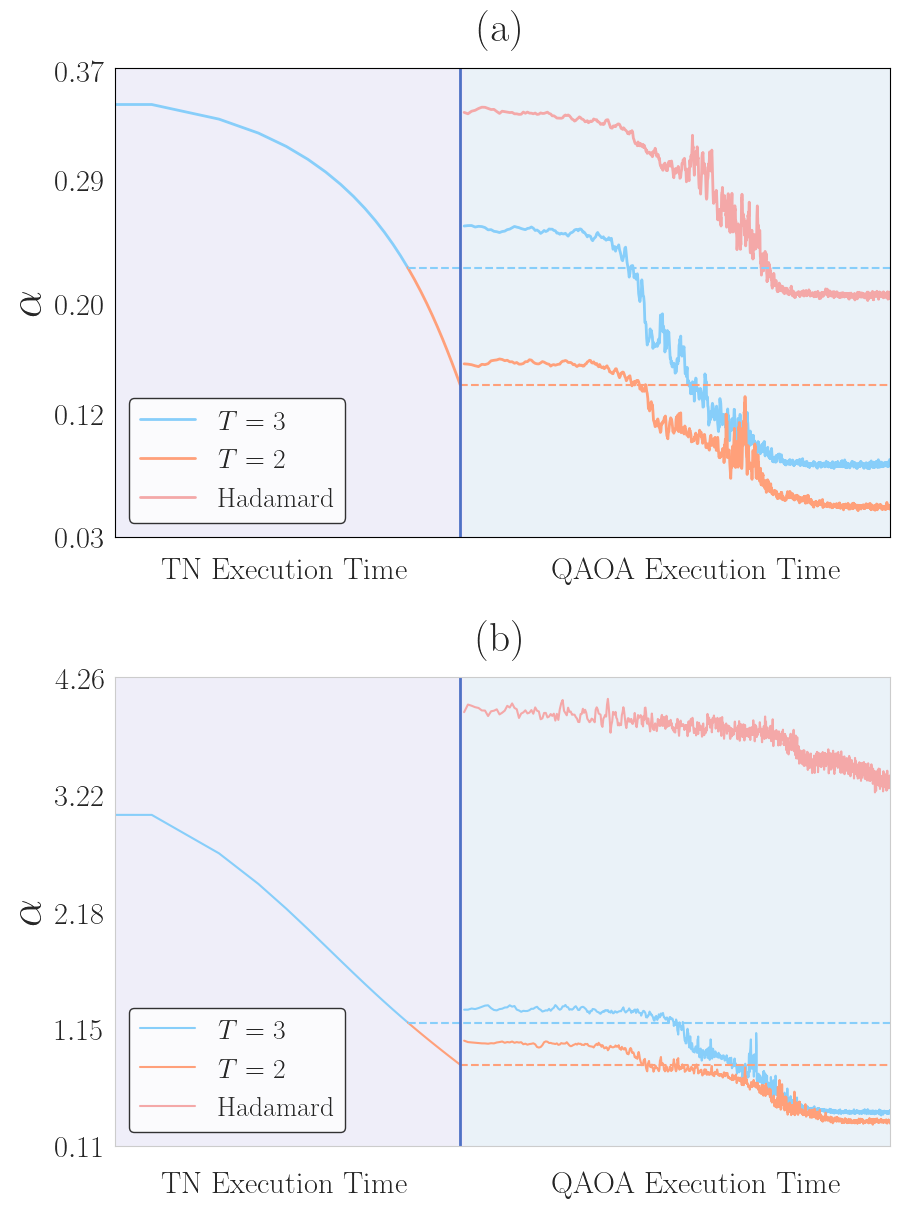

In [19]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')


rc('text', usetex=True)
rc('font', family='serif', weight='bold')


energy_tevo_50_smooth = [energy_tevo_50[i] for i in range(1, len(energy_tevo_50), 2)]
energy_tevo_50_smooth_tsp = [energy_tevo_50_tsp[i] for i in range(1, len(energy_tevo_50_tsp), 2)]

window_size_1 = 5
data_qaoa_30_smooth = moving_average(data_qaoa_30, window_size=window_size_1)
data_qaoa_50_smooth = moving_average(data_qaoa_50, window_size=window_size_1)
data_qaoa_hadamard_smooth = moving_average(data_qaoa_hadamard, window_size=window_size_1)

window_size_2 = 3
data_qaoa_30_smooth_2 = moving_average(data_qaoa_30_tsp, window_size=window_size_2)
data_qaoa_50_smooth_2 = moving_average(data_qaoa_50_tsp, window_size=window_size_2)
data_qaoa_hadamard_smooth_2 = moving_average(data_qaoa_hadamard_tsp, window_size=window_size_2)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 14), sharex=True)
fig.subplots_adjust(hspace=0.3) 


ax1.set_xscale('log')


sns.lineplot(x=range(15), y=energy_tevo_50_smooth[:15], linestyle='-', linewidth=2, color='#87CEFA', ax=ax1)
sns.lineplot(x=range(14, len(energy_tevo_50_smooth)), y=energy_tevo_50_smooth[14:], linestyle='-', linewidth=2, color='#FFA07A', ax=ax1)

start_point = len(energy_tevo_50_smooth)

sns.lineplot(x=range(start_point, start_point + len(data_qaoa_30_smooth)), 
             y=data_qaoa_30_smooth, label=r'$T=3$', linestyle='-', linewidth=2, color='#87CEFA', ax=ax1)
sns.lineplot(x=range(start_point, start_point + len(data_qaoa_50_smooth)), 
             y=data_qaoa_50_smooth, label=r'$T=2$', linestyle='-', linewidth=2, color='#FFA07A', ax=ax1)
sns.lineplot(x=range(start_point, start_point + len(data_qaoa_hadamard_smooth)), 
             y=data_qaoa_hadamard_smooth, label='Hadamard', linestyle='-', linewidth=2, color='#F4A8A8', ax=ax1)

ax1.axvspan(0, 25, facecolor='#6a5acd', alpha=0.1)
ax1.axvspan(25, len(data_qaoa_hadamard_smooth), facecolor='#3288bd', alpha=0.1)

ax1.set_xlim(0, len(data_qaoa_hadamard_smooth)) 

ax1.hlines(y=energy_tevo_50_smooth[14], xmin=14, xmax=10000, colors='#87CEFA', linestyles='dashed', linewidth=1.5)
ax1.hlines(y=energy_tevo_50_smooth[24], xmin=24, xmax=10000, colors='#FFA07A', linestyles='dashed', linewidth=1.5)
ax1.axvline(x=24, color='#4e71c5', linestyle='-', linewidth=2)

ax1.set_ylabel(r'$\alpha$', fontsize=32)

ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_color('black')

ymin, ymax = ax1.get_ylim()
yticks = np.linspace(ymin, ymax, 5)
yticks_rounded = np.round(yticks, 2)
ax1.set_yticks(yticks_rounded)
ax1.tick_params(axis='y', labelsize=22)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax1.text(3.9, 0, 'TN Execution Time', horizontalalignment='center', fontsize=22)
ax1.text(6.5**3, 0, 'QAOA Execution Time', horizontalalignment='center', fontsize=22)
ax1.grid(False)
ax1.set_xticks([])  
ax1.set_title("(a)", pad=20, fontsize=30)
ax1.legend(loc='lower left', bbox_to_anchor=(0, 0), fontsize=20, frameon=True, edgecolor='black')


ax2.set_xscale('log')

sns.lineplot(x=range(15), y=energy_tevo_50_smooth_tsp[:15], linestyle='-', linewidth=1.5, color='#87CEFA', ax=ax2)
sns.lineplot(x=range(14, len(energy_tevo_50_smooth_tsp)), y=energy_tevo_50_smooth_tsp[14:], linestyle='-', linewidth=1.5, color='#FFA07A', ax=ax2)

sns.lineplot(x=range(start_point, start_point + len(data_qaoa_30_smooth_2)), 
             y=data_qaoa_30_smooth_2, label=r'$T=3$', linestyle='-', linewidth=1.5, color='#87CEFA', ax=ax2)
sns.lineplot(x=range(start_point, start_point + len(data_qaoa_50_smooth_2)), 
             y=data_qaoa_50_smooth_2, label=r'$T=2$', linestyle='-', linewidth=1.5, color='#FFA07A', ax=ax2)
sns.lineplot(x=range(start_point, start_point + len(data_qaoa_hadamard_smooth_2)), 
             y=data_qaoa_hadamard_smooth_2, label='Hadamard', linestyle='-', linewidth=1.5, color='#F4A8A8', ax=ax2)

ax2.axvspan(0, 25, facecolor='#6a5acd', alpha=0.1)
ax2.axvspan(25, len(data_qaoa_hadamard_smooth_2), facecolor='#3288bd', alpha=0.1)

ax2.set_xlim(0, len(data_qaoa_hadamard_smooth_2)) 

ax2.hlines(y=energy_tevo_50_smooth_tsp[14], xmin=14, xmax=10000, colors='#87CEFA', linestyles='dashed', linewidth=1.5)
ax2.hlines(y=energy_tevo_50_smooth_tsp[24], xmin=24, xmax=10000, colors='#FFA07A', linestyles='dashed', linewidth=1.5)
ax2.axvline(x=24, color='#4e71c5', linestyle='-', linewidth=2)

ax2.set_ylabel(r'$\alpha$', fontsize=32)

ymin, ymax = ax2.get_ylim()
yticks = np.linspace(ymin, ymax, 5)
yticks_rounded = np.round(yticks, 2)
ax2.set_yticks(yticks_rounded)
ax2.tick_params(axis='y', labelsize=22)

ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax2.grid(False)
ax2.set_title("(b)", pad=20, fontsize=30)
ax2.tick_params()
ax2.text(3.9, -0.3, 'TN Execution Time', horizontalalignment='center', fontsize=22)
ax2.text(6.5**3, -0.3, 'QAOA Execution Time', horizontalalignment='center', fontsize=22)
ax2.legend(fontsize=20, frameon=True, edgecolor='black')

plt.show()


## **Figure 8: DMRG-VQE optimization**

In [20]:
################################################## Max Cut ##################################################

path_data_qaoa_tevo = f"logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe/case_0_max_cut_dmrg_vqe_linear.json"
        
with open(path_data_qaoa_tevo) as f:
    
    data_dmrg = json.load(f)

exact_energy_max_cut = data_dmrg['exact_energy']

energy_dmrg_max_cut = [abs(data_dmrg['energy_dmrg'][i] - exact_energy_max_cut)/abs(exact_energy_max_cut) for i in range(len(data_dmrg['energy_dmrg']))]

steps_dmrg_max_cut = len(energy_dmrg_max_cut)

path_data_qaoa_tevo_quantum = f"logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe/case_0_max_cut_dmrg_vqe_quantum_linear.json"
        
with open(path_data_qaoa_tevo_quantum) as f:
    
    data_tevo_vqe = json.load(f)

data_vqe_max_cut = [abs(data_tevo_vqe[i]['energy'] - exact_energy_max_cut)/abs(exact_energy_max_cut) for i in range(len(data_tevo_vqe))]


################################################## TSP ##################################################

path_data_qaoa_tevo = f"logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe/case_0_tsp_dmrg_vqe_linear.json"
        
with open(path_data_qaoa_tevo) as f:
    
    data_dmrg = json.load(f)

exact_energy_tsp = data_dmrg['exact_energy']

energy_dmrg_tsp = [abs(data_dmrg['energy_dmrg'][i] - exact_energy_tsp)/abs(exact_energy_tsp) for i in range(len(data_dmrg['energy_dmrg']))]

steps_dmrg_tsp = len(energy_dmrg_tsp)

path_data_qaoa_tevo_quantum = f"logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe/case_0_tsp_dmrg_vqe_quantum_linear.json"
        
with open(path_data_qaoa_tevo_quantum) as f:
    
    data_tevo_vqe_tsp = json.load(f)

data_vqe_tsp = [abs(data_tevo_vqe_tsp[i]['energy'] - exact_energy_tsp)/abs(exact_energy_tsp) for i in range(len(data_tevo_vqe_tsp))]

energy_dmrg_max_cut_r = [energy_dmrg_max_cut[i] for i in range(1, len(energy_dmrg_max_cut), 2)]
data_pre_dmrg_vqe_max_cut = energy_dmrg_max_cut_r[:24] + data_vqe_max_cut[:1000]

energy_dmrg_tsp_r = [energy_dmrg_tsp[i] for i in range(1, len(energy_dmrg_tsp), 2)]
data_pre_dmrg_vqe_tsp = energy_dmrg_tsp_r[:24] + data_vqe_tsp[:1000]

C:\Users\anava\AppData\Local\Temp\ipykernel_2072\891277268.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(0, len(data_pre_dmrg_vqe_max_cut_smooth))


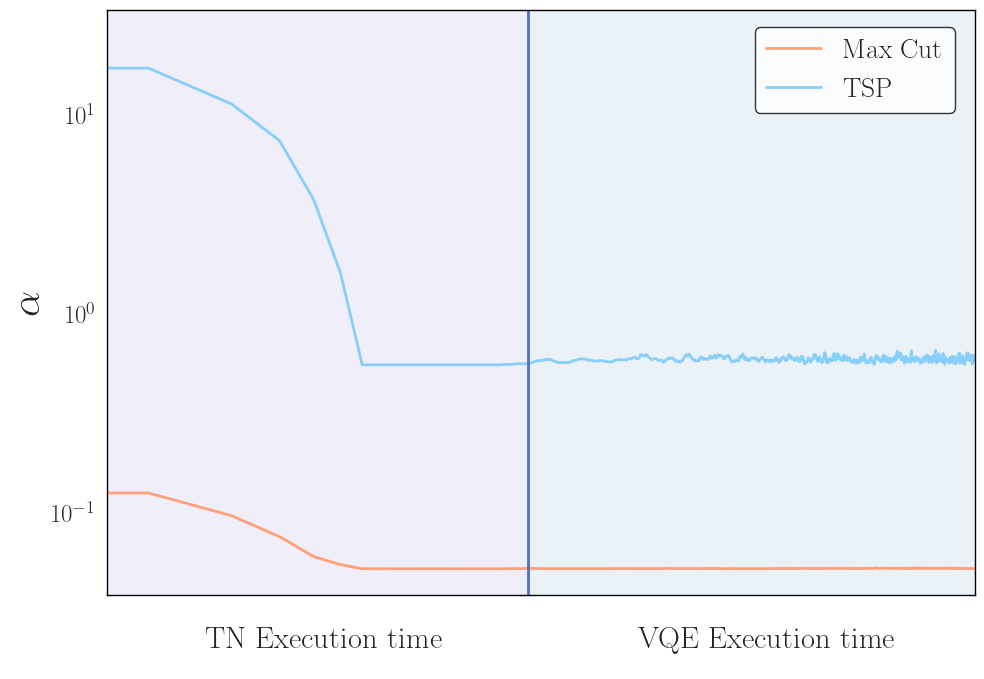

In [21]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

rc('text', usetex=True)
rc('font', family='serif')


window_size = 5
data_pre_dmrg_vqe_max_cut_smooth = moving_average(data_pre_dmrg_vqe_max_cut, window_size=window_size)
data_pre_dmrg_vqe_tsp_smooth = moving_average(data_pre_dmrg_vqe_tsp, window_size=window_size)


start_point = 24 


fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [10, 1]}, figsize=(10, 7))


ax1.set_xscale('log')
ax1.set_yscale('log')


colors = {'tsp_vqe': '#87CEFA', 'max_cut_vqe': '#FFA07A'}
styles = {'quantum': '-', 'tn': '-'}  


sns.lineplot(ax=ax1, x=range(len(data_pre_dmrg_vqe_max_cut_smooth)), y=data_pre_dmrg_vqe_max_cut_smooth, 
             color=colors['max_cut_vqe'], linestyle=styles['tn'], linewidth=2, label='Max Cut')
sns.lineplot(ax=ax1, x=range(len(data_pre_dmrg_vqe_tsp_smooth)), y=data_pre_dmrg_vqe_tsp_smooth, 
             color=colors['tsp_vqe'], linestyle=styles['tn'], linewidth=2, label='TSP')



ax1.axvspan(0, 24, facecolor='#6a5acd', alpha=0.1)
ax1.axvspan(24, len(data_pre_dmrg_vqe_tsp_smooth), facecolor='#3288bd', alpha=0.1)
ax1.axvline(x=24, color='#4e71c5', linestyle='-', linewidth=2)


ax1.set_ylabel(r'$\alpha$', fontdict={'family': 'serif', 'size': 30})


ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=False)
ax1.tick_params(axis='y', which='both', bottom=True, top=False, labelbottom=False, labeltop=False)
ax1.set_xlim(0, len(data_pre_dmrg_vqe_max_cut_smooth))
ax1.tick_params(axis='y', labelsize=18)

for spine in ax1.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)  


ax2.set_xlim(1, 1000)
ax2.set_ylim(0, 1)
ax2.axis('off') 


ax2.text(250, 0.5, 'TN Execution time', horizontalalignment='center', verticalalignment='center', fontdict={'family': 'serif', 'size': 22})
ax2.text(760, 0.5, 'VQE Execution time', horizontalalignment='center', verticalalignment='center', fontdict={'family': 'serif', 'size': 22})


legend = ax1.legend(title_fontproperties={'family': 'serif', 'size': 20}, prop={'family': 'serif', 'size': 20}, loc='lower left', bbox_to_anchor=(0.73, 0.80), ncol=1)
frame = legend.get_frame()
frame.set_edgecolor('black')
frame.set_linewidth(1)  

ax1.grid(False)
ax2.grid(False)
plt.tight_layout()
plt.show()

## **Figure 9: Gibbs states from MPO Time Evolution**

In [22]:
n_nodes = 8

instance_max_cut = MaxCut_Instance(n_nodes)
instance_max_cut.import_from_file('logger_data/logger_data_pretraining_su4/gibbs_states_from_mpo_time_evolution/max_cut_instance_n_8_gibbs_states_for_mpo')

cost_function_max_cut = MaxCut_CostFunction(instance_max_cut)


n_qubits = cost_function_max_cut.num_bin_vars

exact_solution = float(instance_max_cut.brute_force()[0][2])

print('Exact solution:', exact_solution)


energy_x_list_list_steps = []
pb_log_y_list_list_steps = []
pearson_list_steps = []

for steps in [10, 35, 70, 95]:

    pre = Pretraining(ham = cost_function_max_cut.total_hamiltonian,
                    n_qubits = n_qubits,
                    chi_mpo = 32,
                    fidelity_mps = 1.0,
                    sweeps_mps = 100,
                    init_layers_mps = 2,
                    layers_su4 = 1,
                    connectivity_su4 = 'Linear'
                    )

    pretraining_tevo = pre.time_evolution_pretraining(n_steps = steps,
                                                    dt = 0.01,
                                                    order = 2, 
                                                    init_mps = None,
                                                    metrics = True)
    
    probs_list = []
    
    for i in range(2**n_qubits):
        sol_string = bin(i)[2:].zfill(n_qubits)
        prob = abs(TensorOperations(pre.final_mps.tensors).proyection_state(sol_string))**2
        probs_list.append((sol_string, prob))

    probs_list = sorted(probs_list, key=lambda tup: tup[1], reverse=True)

    energy_x_list = []
    pb_log_y_list = []
    
    for i in range(len(probs_list)):
        
        energy_x_list.append(cost_function_max_cut.check_cost_binary(str(probs_list[i][0])))
        pb_log_y_list.append(np.log(np.sqrt(probs_list[i][1])))
    
    energy_x_list_list_steps.append(energy_x_list)
    pb_log_y_list_list_steps.append(pb_log_y_list)
    
    coeficiente_pearson, valor_p = pearsonr(energy_x_list, pb_log_y_list)
    
    pearson_list_steps.append(coeficiente_pearson)

energy_x_list_list_chi = []
pb_log_y_list_list_chi = []
pearson_list_chi = []

for chi in [8, 16, 32, 64]:

    pre = Pretraining(ham = cost_function_max_cut.total_hamiltonian,
                    n_qubits = n_qubits,
                    chi_mpo = chi,
                    fidelity_mps = 1.0,
                    sweeps_mps = 100,
                    init_layers_mps = 2,
                    layers_su4 = 1,
                    connectivity_su4 = 'Linear'
                    )

    pretraining_tevo = pre.time_evolution_pretraining(n_steps = 60,
                                                    dt = 0.01,
                                                    order = 2, 
                                                    init_mps = None,
                                                    metrics = True)
    
    probs_list = []
    
    for i in range(2**n_qubits):
        sol_string = bin(i)[2:].zfill(n_qubits)
        prob = abs(TensorOperations(pre.final_mps.tensors).proyection_state(sol_string))**2
        probs_list.append((sol_string, prob))

    probs_list = sorted(probs_list, key=lambda tup: tup[1], reverse=True)

    energy_x_list = []
    pb_log_y_list = []
    
    for i in range(len(probs_list)):
        
        energy_x_list.append(cost_function_max_cut.check_cost_binary(str(probs_list[i][0])))
        pb_log_y_list.append(np.log(np.sqrt(probs_list[i][1])))
    
    energy_x_list_list_chi.append(energy_x_list)
    pb_log_y_list_list_chi.append(pb_log_y_list)
    
    coeficiente_pearson, valor_p = pearsonr(energy_x_list, pb_log_y_list)
    
    pearson_list_chi.append(coeficiente_pearson)

Exact solution: -11.0


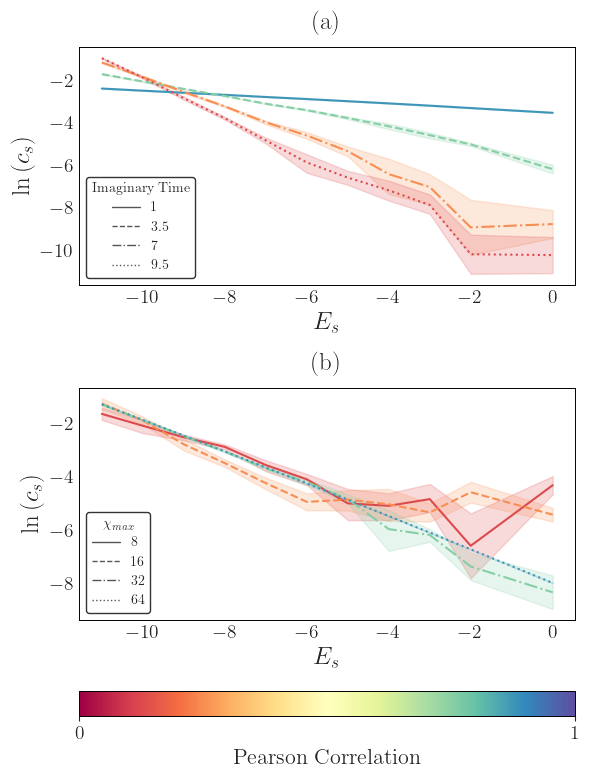

In [23]:
rc('text', usetex=True)
rc('font', family='serif')
plt.rc('font', family='serif', weight='light')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12), gridspec_kw={'height_ratios': [2, 3]})


palette = sns.color_palette("Spectral", n_colors=7)
colors = [palette[6], palette[5], palette[1], palette[0]]
linestyles = ['-', '--', '-.', ':']
custom_lines = [Line2D([0], [0], color='#555555', linestyle=linestyle, linewidth=1) for linestyle in linestyles]


data_list = []
for i, (x, y, z) in enumerate(zip(energy_x_list_list_steps, pb_log_y_list_list_steps, pearson_list_steps), start=1):
    df_temp = pd.DataFrame({'x': x, 'y': y, 'z': z})
    df_temp['label'] = f'{i*2-1}'
    data_list.append(df_temp)

df_steps = pd.concat(data_list)


for i in range(4):
    sns.lineplot(data=df_steps[df_steps['label'] == f'{i*2+1}'], x='x', y='y', color=colors[i], linestyle= linestyles[i], ax=ax1, label=f'{i*2+1}')

ax1.tick_params(axis='x', which='both', length=0)
ax1.tick_params(axis='y', which='both', length=0)

ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=8))
ax1.yaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=8))

ax1.yaxis.grid(True, linestyle='--', linewidth=0.7)

ax1.set_xlabel(r'$E_s$', fontdict={'family': 'serif', 'size': 18})
ax1.set_ylabel(r'$\ln{(c_s)}$', fontdict={'family': 'serif', 'size': 18})
ax1.legend(handles=custom_lines, labels=[1, 3.5, 7, 9.5], title=r"Imaginary Time", title_fontproperties={'family': 'serif', 'size': 10}, prop={'family': 'serif', 'size': 10}, frameon=True, edgecolor='black')


ax1.text(0.5, 1.05, '(a)', transform=ax1.transAxes, fontsize=18, fontfamily='serif',
         verticalalignment='bottom', horizontalalignment='center')

data_list = []
for i, (x, y, z) in enumerate(zip(energy_x_list_list_chi, pb_log_y_list_list_chi, pearson_list_chi), start=1):
    df_temp = pd.DataFrame({'x': x, 'y': y, 'z': z})
    df_temp['label'] = f'{2**i}'
    data_list.append(df_temp)

colors = [palette[0], palette[1], palette[5], palette[6]]

df_chi = pd.concat(data_list)

for i in range(4):
    sns.lineplot(data=df_chi[df_chi['label'] == f'{2**(i+1)}'], x='x', y='y', linestyle= linestyles[i], color=colors[i], ax=ax2, label=f'{2**(i+1)}')

ax2.tick_params(axis='x', which='both', length=0)
ax2.tick_params(axis='y', which='both', length=0)

ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=8))
ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=8))

ax2.yaxis.grid(True, linestyle='--', linewidth=0.7)

ax2.set_xlabel(r'$E_s$', fontdict={'family': 'serif', 'size': 18})
ax2.set_ylabel(r'$\ln{(c_s)}$', fontdict={'family': 'serif', 'size': 18})
ax2.legend(handles=custom_lines, labels=[f'{2**(i+3)}' for i in range(4)], title=r"$\chi_{max}$", title_fontproperties={'family': 'serif', 'size': 10}, prop={'family': 'serif', 'size': 10}, loc='lower left', frameon=True, edgecolor='black')


ax2.text(0.5, 1.05, '(b)', transform=ax2.transAxes, fontsize=18, fontfamily='serif',
         verticalalignment='bottom', horizontalalignment='center')


norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap=sns.color_palette("Spectral", as_cmap=True), norm=norm)
sm.set_array([])

fig.subplots_adjust(bottom=0.25)  


cbar = fig.colorbar(sm, ax=ax2, orientation='horizontal', pad=0.2)
cbar.set_label('Pearson Correlation', fontsize=16, fontfamily='serif')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0', '1'])
ax2.grid(False)
ax1.grid(False)
cbar.outline.set_edgecolor('black') 
cbar.outline.set_linewidth(0.7)   

for ax in [ax1, ax2]:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')  
        spine.set_linewidth(0.7)


plt.tight_layout(rect=[0, 0.3, 1, 0.95]) 

plt.show()


## **Figure 10: Area calculation**

In [24]:
def concave_enclosing_area(puntos, alpha):

    alpha_shape = alphashape.alphashape(puntos, alpha)
    return alpha_shape.area, alpha_shape

def compute_probabilities(init_state, alpha, beta):
    point_probabilities = []
    for a in alpha:
        for b in beta:
            
            final_parameters = np.array([a, b])
            
            qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)
            
            qaoa.set_parameters(final_parameters)
            
            quantum_state = qaoa.execute(initial_state = init_state)
            
            probabilities = np.real(quantum_state*quantum_state.conj())
            
            point_probabilities.append(probabilities)
    return point_probabilities

n = 6
p = 0.5

G = nx.erdos_renyi_graph(n, p, seed = 4)

dict_values = exprectum_hamiltonian(G)

gibbs_state = create_gibbs_state(dict_values, t = 5)

expected_value_gibbs_state = expected_value(state = gibbs_state, dict_values = dict_values)


hamiltonian = build_maxcut_hamiltonian(graph = G)

mixer_hamiltonian = build_mixer_hamiltonian(graph = G)


alpha = np.linspace(0, 2 * np.pi, 50)
beta = np.linspace(0, 2 * np.pi, 50)

angle_params = []

point_probabilities = []

for a in alpha:
    for b in beta:
        
        angle_params.append([alpha,beta])
        
        final_parameters = np.array([a, b])
        
        qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)
        
        qaoa.set_parameters(final_parameters)
        
        quantum_state = qaoa.execute(initial_state = gibbs_state)
        
        probabilities = np.real(quantum_state*quantum_state.conj())
        point_probabilities.append(probabilities)
        

angle_params = np.array(angle_params)

angle_params = []
for a in alpha:
    for b in beta:
        angle_params.append([a,b])
angle_params = np.array(angle_params)

pca = PCA(n_components = 4)
pca_point_probabilities = pca.fit_transform(np.array(point_probabilities))
componentsDf = pd.DataFrame(data = pca_point_probabilities, columns = ['PC1', 'PC2', 'PC3', 'PC4'])
componentsDf["alpha"] = angle_params[:,0]
componentsDf["beta"] = angle_params[:,1]

alpha = 50
area, alpha_shape = concave_enclosing_area(componentsDf[['PC1','PC2']].to_numpy(), alpha)

C:\Users\anava\AppData\Local\Temp\ipykernel_2072\1556175740.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=componentsDf, x="PC1", y="PC2",


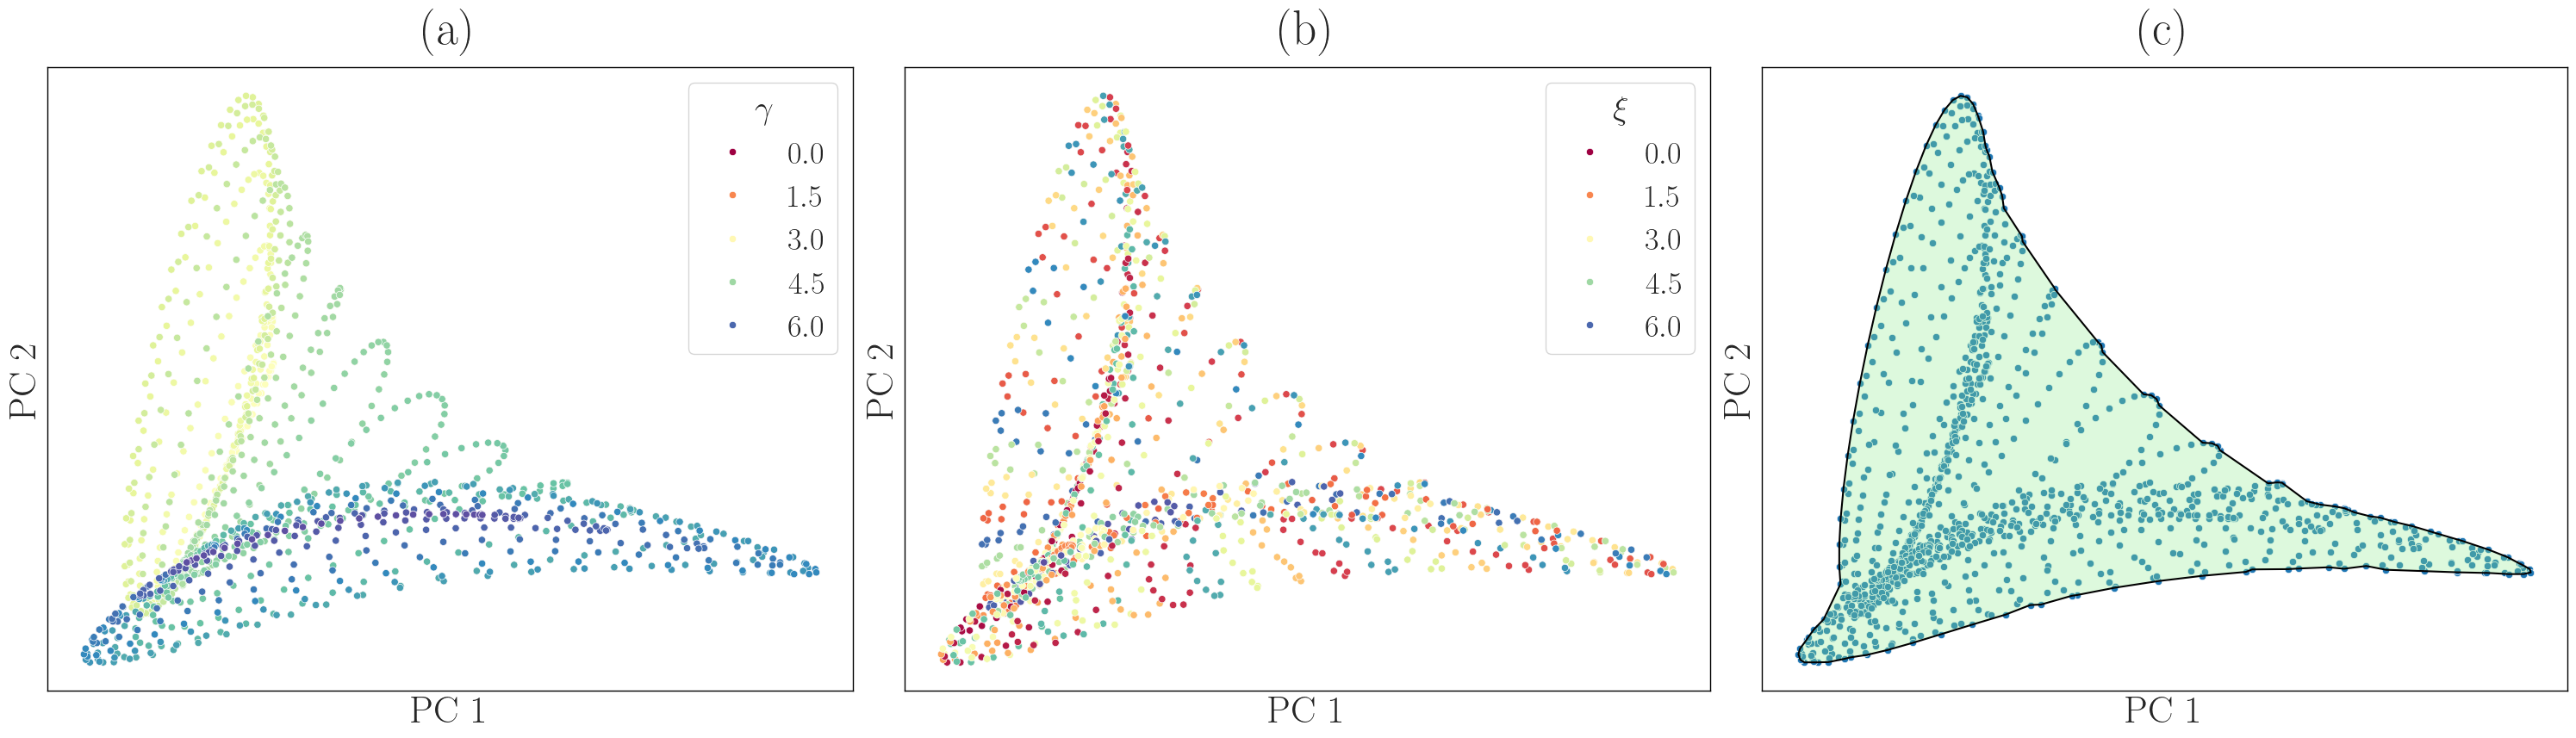

In [25]:
plt.rc('font', family='serif')


fig, ax = plt.subplots(1, 3, figsize=(30, 10))  


scatter1 = sns.scatterplot(data=componentsDf, x="PC1", y="PC2", hue='alpha', 
                           palette=sns.color_palette("Spectral", as_cmap=True), ax=ax[0])

ax[0].set_xlabel("PC 1", fontsize=32)  
ax[0].set_ylabel("PC 2", fontsize=32)  

scatter1.legend(title=r"$\gamma$", title_fontsize='28', fontsize='26')


scatter2 = sns.scatterplot(data=componentsDf, x="PC1", y="PC2", hue='beta', 
                palette=sns.color_palette("Spectral", as_cmap=True), ax=ax[1])

ax[1].set_xlabel("PC 1", fontsize=32)  
ax[1].set_ylabel("PC 2", fontsize=32)

scatter2.legend(title=r"$\xi$", title_fontsize='28', fontsize='26')


alpha_shape = alphashape.alphashape(componentsDf[['PC1','PC2']].to_numpy(), alpha)

sns.scatterplot(data=componentsDf, x="PC1", y="PC2", 
                palette=sns.color_palette("Spectral", as_cmap=True), ax=ax[2])


if isinstance(alpha_shape, Polygon):
    x, y = alpha_shape.exterior.xy
    ax[2].plot(x, y, 'k-', lw=1.5)  
    ax[2].fill(x, y, 'lightgreen', alpha=0.3)  

ax[2].set_facecolor('white')
ax[2].set_xlabel("PC 1", fontsize=32)  
ax[2].set_ylabel("PC 2", fontsize=32)


for i in range(3):
    ax[i].set_aspect('equal', adjustable='box')
    ax[i].grid(False)


ax[0].set_title('(a)', fontsize=40, pad=20)
ax[1].set_title('(b)', fontsize=40, pad=20)
ax[2].set_title('(c)', fontsize=40, pad=20)

for ax in [ax[0], ax[1], ax[2]]:
    for spine in ax.spines.values():
        spine.set_edgecolor('black') 
        spine.set_linewidth(1)
        ax.set_xticks([])
        ax.set_yticks([])


plt.tight_layout()
plt.show()